# Final Project Report

* Class: DS 5100
* Student Name: Alysa Pugmire
* Student Net ID: amp3xs
* This URL: https://github.com/apugmire/monte_carlo_sim/blob/main/DS51200_FinalProjectTemplate.ipynb

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/apugmire/monte_carlo_sim

Paste a copyy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

```python
import pandas as pd
import numpy as np
import itertools

class Die():
    '''
    This class provides methods for creating a rolling a dice. For this class, a die is any discrete random variable 
    associated with a stochastic process. 
    
    Attributes:
    
    faces: the sides the die has. Each side must contain a unique string or number (type: numpy array).
    weights: the probability each side will land "up" when rolled (type: list of int or float).
    '''
    
    def __init__(self, faces):
        '''initialize the die instance. Weight defaults to 1 for each face but can be changed after the object is created'''
        self.faces = faces
        
        #check that faces is an np array
        if type(self.faces) != np.ndarray:
            raise TypeError("Faces must be NumPy array")
        
        #check if faces are all unique"
        if len(self.faces) != len(np.unique(self.faces)):
            raise ValueError("All faces must be unique")
        self.weights = [1.0 for i in self.faces]
        self._die = pd.DataFrame({'weights' : self.weights}, index = self.faces)
        self._die.index.name = "Faces"
        
    def change_weight(self,face,weight):
        '''
        Takes an integer or float parameter and changes the weight of one face if that face is on the die and the weight is 
        a valid value. Will attempt to cast the provided parameter to a float if possible.
        '''
        
        #check if provided value is a face
        if face not in list(self._die.index):
            raise IndexError(face, "is not a face on this die.")
        
        #check is weight is int, float, or can be casted to int
        if type(weight) != int | float:
            try:
                weight = float(weight)
            except TypeError as e:
                print(e)
        
        #change weight
        self._die.loc[(face,'weights')] = weight
    
    def roll_die(self, rolls=1):
        '''takes an integer parameter to specify how many times the dice should be rolled. Default is 1 roll'''
        
        #calculate probablity of rolling each face
        prob = [i/sum(self._die.weights) for i in self._die.weights]
        
        # get random sample of faces based on probability associated with rolling each then return the list
        return [np.random.choice(self._die.index, replace = True, p=prob) for i in range(rolls)]
            
    def current_state(self):
        '''Takes no arguments and returns a copy of the die at this point in time'''
        
        copy = self._die.copy()
        
        return copy

class Game():
    
    '''
    This class provides methods for playing a game with a die or dice and viewing the results. These methods require a die
    or dice from the Die class. The die must also be similar, i.e. they must have the same number of sides and associated
    faces, but each die object may have its own weights.

    Game objects only keep the results of their most recent play.

    Attributes:
    
    pieces: a list of already instantiated similar dice to be used in the game (type: list)
    '''
    
    def __init__(self,pieces):
        '''initialize the list of die/dice to be used in the game.'''
        
        self.pieces = pieces
        
    def play_game(self, rolls):
        '''
        takes an integer parameter to specify how many times the dice should be rolled and saves the result of the
        roll(s) in a wide format data frame. Does not return anything but changes the object's state.
        '''
        
        # roll each dice in the list and store the results in a dictionary 
        # where the key is the position in the list and the value is the list of results
        outcome = {i: self.pieces[i].roll_die(rolls) for i in range(len(self.pieces))}
        
        # convert dictionary into a dataframe where the column names are the list index 
        # and the row names are the roll number
        self._play_results  = pd.DataFrame(outcome, index=[i for i in range(0,rolls)])
        self._play_results.index.name = "roll_num"
        self._play_results.columns.name = "dice_num"
        
    def show_outcome(self, form="wide"):
        '''
        takes a string parameter (either "wide" or "narrow") and returns a copy of game outcome to the user 
        in either wide or narrow form.
        
        The narrow form will have a MultiIndex, comprising the roll number and the die number and a single column with the 
        outcomes
        '''
        
        # convert parameter entry to all lowercase
        self.form = form.lower()
        
        # if user indicates wide form, return a copy of the data frame as is
        if self.form == "wide":
            return self._play_results
        
        # if user indicates wide form, format data frame and return a copy
        elif self.form == "narrow":
            
            # convert copy of wide data frame into narrow version
            narrow = self._play_results.copy().stack()
        
            #set multiindex names
            narrow.index.set_names(["roll_num","die_num"], inplace=True)
            
            # turn into a dataframe
            narrow = narrow.to_frame(name="outcome")
            
            # return narrow format data frame
            return narrow
        
        # if the uswer enters anything else, raise a error
        else:
            raise ValueError("Please specify either narrow or wide.")

class Analyzer():
    '''
    This class provides methods for analyzing the results of a single game. These methods require a game from the Game 
    class. This class takes the results of a single game and computes various descriptive statistical properties about it.

    Attributes:
    
    game: an instantiated game object (type: Game)
    '''
    
    def __init__(self,game):
        '''
        Takes a game object as its input parameter. Throws a ValueError if the passed value is not a Game object.
        '''
        if type(game) != Game:
            raise ValueError("This method only accepts Game objects")
        else:
            self.game = game
    
    def jackpot(self):
        '''
        Takes no parameters. Computes how many times the game resulted in a jackpot. A jackpot is a result in which all
        faces are the same. Returns an integer for the number of jackpots.
        '''
        # get a series which shows the number of unique values in each row
        uniques = self.game._play_results.nunique(axis=1)
        
        # find home many rows in this series have only 1 unique value
        jackpot = sum(uniques== 1)
        
        # return number of jackpots
        return jackpot
             
    def face_count(self):
        '''
        Takes no parameters. Computes how many times each face is rolled in each event. Returns a dataframe where the 
        index is the roll number, the columns are the face values, and cells are the count values.
        '''
        # get list of all possible faces to use as columns
        all_faces = np.unique(np.concatenate([piece.faces for piece in self.game.pieces]))
        
        #create base dataframe with roll number as index and possible faces as columns
        face_counts = pd.DataFrame(index=self.game._play_results.index, columns = all_faces).fillna(0)
        
        #iterate over rolls and get counts of each face
        for roll in self.game._play_results.index:
        
            # isolate each row
            outcomes = self.game._play_results.loc[roll].values
            
            # count occurance of each face and store in a dictionary where the face is the key and the count is the value
            counts = {face:(outcomes==face).sum() for face in all_faces}
            
            #add counts to data frame
            for face, count in counts.items():
                face_counts.loc[roll,face] = count
                
        return face_counts
    
    def combo_count(self):
        '''
        Takes no parameters. Computes the distinct combinations of faces rolled, along with their counts. The combinations
        are order-independent and repetition is allowed. Returns a data frame with a MultiIndex of distinct combinations and
        a column for the associated counts
        '''
        
        #get the faces from each roll and sort since order does not matter (ex. AAB and ABA are the same)
        faces_rolled = [np.sort(self.game._play_results.loc[roll].values) for roll in self.game._play_results.index]
        
        #convert each face outcome to a tuple for easier counting
        tupes = [tuple(faces) for faces in faces_rolled]
        
        #count how many times each face combo appears and store that in a dictionary 
        count = {tupe:tupes.count(tupe) for tupe in tupes}
        
        #create multiindex
        index = pd.MultiIndex.from_tuples(count.keys(), names = [i for i in range(len(next(iter(count))))])
        
        #create datafram with multiindex and column with counts
        combo_counts = pd.DataFrame({'Count': list(count.values())}, index=index)
        combo_counts = combo_counts.sort_index()
        
        return combo_counts
    
    def perm_count(self):
        '''
        Takes no parameters. Computes the distinct permutations of faces rolled, along with their counts. The permutations
        are order-dependent and repetition is allowed. Returns a data frame with a MultiIndex of distinct permutations and a
        column for the associated counts
        '''
        #get the faces from each roll, no sorting since order matters
        faces_rolled = [self.game._play_results.loc[roll].values for roll in self.game._play_results.index]
        
        #convert each face outcome to a tuple for easier counting
        tupes = [tuple(faces) for faces in faces_rolled]
        
        #count how many times each face combo appears and store that in a dictionary 
        count = {tupe:tupes.count(tupe) for tupe in tupes}
        
        #create multiindex
        index = pd.MultiIndex.from_tuples(count.keys(), names = [i for i in range(len(next(iter(count))))])
        
        #create datafram with multiindex and column with counts
        perm_counts = pd.DataFrame({'Count': list(count.values())}, index=index)
        perm_counts = perm_counts.sort_index()
        
        return perm_counts
```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

```python
import unittest
import pandas as pd
import numpy as np

from monte_carlo import Die, Game, Analyzer

class DieTestSuite(unittest.TestCase):
    
    def test_01_create_die(self):
        
        reg = np.array([1,2,3,4,5,6]) 
        
        die1 = Die(reg) #create die with 6 faces
                       
        self.assertTrue(type(die1)==Die and len(die1.faces)==6) # confirm type is die and there are 6 faces
        
    def test_02_change_weight_bad(self):
        
        alph = np.array(["A","B","C","D"]) 
        
        die2 = Die(alph) #create die with 4 faces
        
        
        with self.assertRaises(IndexError): #should raise exception since E is not a face
            die2.change_weight("E",10) #change weight of E to 10
        
    def test_03_change_weight_good(self):
    
        alph = np.array(["A","B","C","D"]) 
        
        die3 = Die(alph) #create die with 4 faces
        
        die3.change_weight("B",6) #change weight of B to 6
        
        actual = die3._die.loc[("B", "weights")]
        
        expected = 6
        
        self.assertEqual(actual,expected) #test if the weight of B is now 6
    
    def test_04_roll_die(self):
        
        even = np.array([2,4,6,8,10,12,14,16,18,20])
        
        die4 = Die(even)
        
        actual = die4.roll_die(5) #roll the die 5 times
    
        self.assertTrue(len(actual) == 5 and sum(actual) >= 10) #confirm die was rolled 5 times and resulting values are
                                                                #possible (lowest value that could possibly be rolled is 
                                                                #5 2's so 10
        
    def test_05_current_state(self):
        
        odd = np.array([1,3,5])
        
        die5 = Die(odd)
        
        die5.change_weight(1,5) #change weight of once face
        
        state = die5.current_state()
        
        self.assertIsInstance(state, pd.DataFrame) #check the copy is a data frame
        
        self.assertEqual(list(state.index), odd.tolist()) #check the faces are actually the faces
        
        expectedwt = [5.0,1.0,1.0]
        actualwt = state['weights'].tolist()
        
        self.assertEqual(actualwt, expectedwt)
    
class GameTestSuite(unittest.TestCase):

    def test_06_create_game(self):
        
        die6 = Die(np.array(["A","B","C"]))
        
        die7 = Die(np.array(["A","B","C"]))
                         
        game1 = Game([die6,die7]) #create game with two dice
                         
        self.assertTrue(type(game1)==Game and len(game1.pieces) ==2) #confirm game1 is a Game with 2 dice
    
    def test_07_play_game(self):
        
        die8 = Die(np.array(["A","B","C"]))
        
        die9 = Die(np.array(["A","B","C"]))
                         
        game2 = Game([die8,die9]) #create game with two dice
        
        game2.play_game(4) # roll each die 4 times
        
        actual = len(game2.show_outcome()) #play_game only updates the object's state, using show_outcome to confirm state
                                           #was updated correcty
        
        expected = 4
        
        self.assertEqual(actual,expected) #confirm each die was rolled 4 times
    
    def test_08_show_outcome_wide(self):
        
        die10 = Die(np.array(["A","B","C"]))
        
        die11 = Die(np.array(["A","B","C"]))
                         
        game3 = Game([die10,die11]) #create game with two dice
        
        game3.play_game(7)
        
        outcome = game3.show_outcome()
        
        self.assertIsInstance(outcome, pd.DataFrame) #check the outcome is a data frame
    
    def test_09_show_outcome_narrow(self):
        
        die12 = Die(np.array(["A","B","C"]))
        
        die13 = Die(np.array(["A","B","C"]))
                         
        game4 = Game([die12,die13]) #create game with two dice
        
        game4.play_game(7) #roll 7 times
        
        outcome = game4.show_outcome('narrow') #how results in narrow form
        
        self.assertIsInstance(outcome, pd.DataFrame) #check the outcome is a data frame
        
        self.assertEqual(outcome.shape, (14,1)) #check there are 14 rows and one column
        
        self.assertEqual(outcome.index.names, ['roll_num', 'die_num']) # check presence of multiindex and index names
    
class AnalyzerTestSuite(unittest.TestCase):
    
    def test_10_create_analyzer_bad(self):
        
        die14 = Die(np.array(["T", "F"]))
        
        die15 = Die(np.array(["T", "F"]))
                         
        game5 = Game([die14,die15]) #create game with two dice
                         
        with self.assertRaises(ValueError):
            a1 = Analyzer(die14) #attempt to initialize with no class
        
    def test_11_create_analyzer_good(self):
        
        die16 = Die(np.array(["T", "F"]))
        
        die17 = Die(np.array(["T", "F"]))
                         
        game6 = Game([die16,die17]) #create game with two dice
                         
        a2 = Analyzer(game6)   
        
        self.assertTrue(type(a2)==Analyzer and len(a2.game.pieces)==2) #confirm a2 is an Analyzer of a Game with 2 pieces
    
    def test_12_jackpot(self):
        
        die18 = Die(np.array(["T"]))
        
        game7 = Game([die18, die18]) #create a Game with two dice
        
        game7.play_game(4) # roll 4 times
        
        a3 = Analyzer(game7) #analyze
        
        actual = a3.jackpot() #since all faces are the same, we should get jackpot every time
        expected = 4
        
        self.assertEqual(actual,expected) #check that we actually did get jackpot each time
    
    def test_13_face_count(self):
                         
        die20 = Die(np.array(["H", "T"]))
        
        die21 = Die(np.array(["H", "T"]))
        
        game8 = Game([die20, die21]) #create a Game with two dice
        
        game8.play_game(10) #play game with 10 rolls
        
        a4 = Analyzer(game8) # analyze
                         
        actual = a4.face_count().shape # should have 10 rows and 2 columns since
                         
        expected = (10,2)
                         
        self.assertIsInstance(a4.face_count(), pd.DataFrame)  # check result is a data frame
        self.assertEqual(actual,expected)                    #check the shape is correct. Should have a row for each roll
                                                             #and a column for each face
    def test_14_combo_count(self):
    
        die22 = Die(np.array(["H", "T"]))
        
        die23 = Die(np.array(["H", "T"]))
        
        game9 = Game([die22, die23]) #create a Game with two dice
        
        game9.play_game(6) #play game with 6 rolls
        
        a5 = Analyzer(game9) #analyze
        
        self.assertIsInstance(a5.combo_count(), pd.DataFrame) #confirm result is a pandas data frame
        self.assertIsInstance(a5.combo_count().index, pd.MultiIndex) #confirm presence of multiindex
        
    def test_15_pem_count(self):
        
        die24 = Die(np.array(["Ace", "King", "Queen", "Jack"]))
        
        die25 = Die(np.array(["Ace", "King", "Queen", "Jack"]))
        
        game10 = Game([die24, die25]) #create a Game with two dice
        
        game10.play_game(100) # play game with 100 rolls
        
        a6 = Analyzer(game10) # analyze
            
        self.assertIsInstance(a6.perm_count(), pd.DataFrame) #confirm result is a pandas data frame
        self.assertIsInstance(a6.perm_count().index, pd.MultiIndex) #confirm presence of multiindex

if __name__ == '__main__':
    
    unittest.main(verbosity=3)
```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [1]:
import monte_carlo.monte

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [2]:
help(monte_carlo.monte)

Help on module monte_carlo.monte in monte_carlo:

NAME
    monte_carlo.monte

CLASSES
    builtins.object
        Analyzer
        Die
        Game
    
    class Analyzer(builtins.object)
     |  Analyzer(game)
     |  
     |  This class provides methods for analyzing the results of a single game. These methods require a game from the Game class. This class takes the results of a single game and computes various descriptive statistical properties about it.
     |  
     |  Attributes:
     |  
     |  game: an instantiated game object (type: Game)
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game)
     |      Takes a game object as its input parameter. Throws a ValueError if the passed value is not a Game object.
     |  
     |  combo_count(self)
     |      Takes no parameters. Computes the distinct combinations of faces rolled, along with their counts. The combinations
     |      are order-independent and repetition is allowed. Returns a data frame with 

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL:

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [3]:
from monte_carlo import Die, Game, Analyzer
import pandas as pd
import numpy as np

fair = Die(np.array(["H","T"]))
unfair = Die(np.array(["H", "T"]))
unfair.change_weight("H",5)

Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [4]:
fair_game = Game([fair,fair])
fair_game.play_game(1000)

Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [5]:
unfair_game = Game([unfair,unfair,fair])
unfair_game.play_game(1000)

Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [6]:
fair_analysis = Analyzer(fair_game)
fair_jack = fair_analysis.jackpot()
fair_jack

494

In [7]:
unfair_analysis = Analyzer(unfair_game)
unfair_jack = unfair_analysis.jackpot()
unfair_jack

381

Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [8]:
rel_fair_jack = fair_jack / 1000
rel_fair_jack

0.494

In [9]:
rel_unfair_jack = unfair_jack / 1000
rel_unfair_jack

0.381

Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

Text(0.5, 1.0, 'Frequency of Jackpot by Die Type')

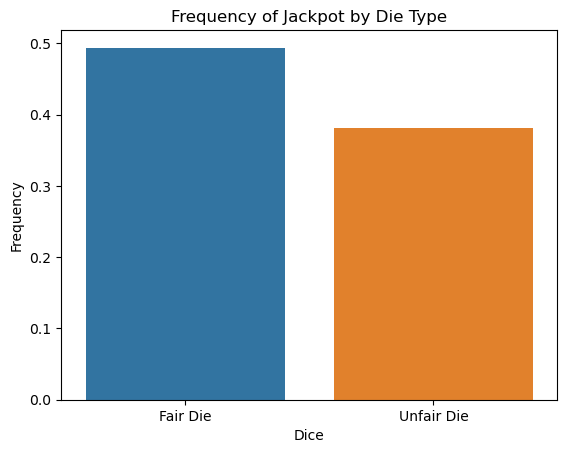

In [14]:
from seaborn import barplot
import matplotlib.pyplot as plt

data = [rel_fair_jack, rel_unfair_jack]
labels = ["Fair Die", "Unfair Die"]

barplot(x=labels, y=data)
plt.xlabel('Dice')
plt.ylabel('Frequency')
plt.title('Frequency of Jackpot by Die Type')

In [ ]:
barplot()

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [15]:
d1 = Die(np.array([1,2,3,4,5,6]))
d2 = Die(np.array([1,2,3,4,5,6]))
d3 = Die(np.array([1,2,3,4,5,6]))

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [16]:
d2.change_weight(6,5)

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [17]:
d1.change_weight(1,5)

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [18]:
game3 = Game([d3,d3,d3,d3,d3])
game3.play_game(10000)

Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [19]:
game4 = Game([d1,d2,d3,d3,d3])
game4.play_game(10000)

Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

In [23]:
analysis3 = Analyzer(game3)
analysis3.jackpot()
fair_jack2 = analysis3.jackpot()
fair_jack2

3

In [24]:
analysis4 = Analyzer(game4)
analysis4.jackpot()
unfair_jack2 = analysis4.jackpot()
unfair_jack2

12

In [25]:
rel_fair_jack2 = fair_jack2 / 10000
rel_unfair_jack2 = unfair_jack2 / 10000

In [27]:
freqs = [rel_fair_jack2, rel_unfair_jack2]
labs = ["Fair Die", "Unfair Die"]

Text(0.5, 1.0, 'Frequency of Jackpot by Die Type')

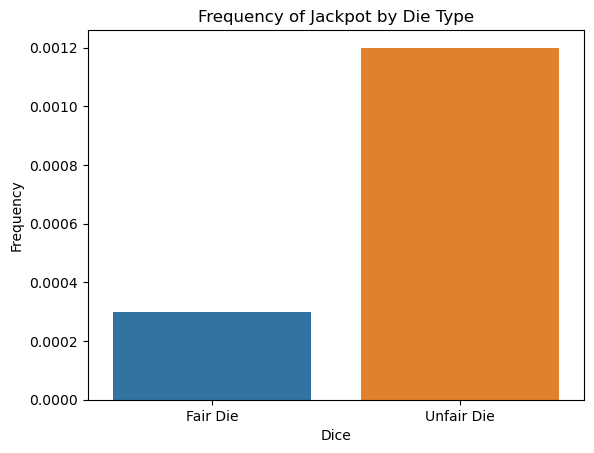

In [28]:
barplot(x=labs, y=freqs)
plt.xlabel('Dice')
plt.ylabel('Frequency')
plt.title('Frequency of Jackpot by Die Type')

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [29]:
#load in data
alphabet = np.genfromtxt('english_letters.txt',dtype=[('letter', 'U1'),('freq', 'i8')])

#extract each column
letters = alphabet['letter']
frequency = alphabet['freq']

#create dice with letters for faces
alph = Die(letters)

#change weights of each face to frequency
for letter, freq in zip(letters,frequency):
    alph.change_weight(letter,freq)

#show die
alph.current_state()

,weights
Faces,
E,529117365.0
T,390965105.0
A,374061888.0
O,326627740.0
I,320410057.0
N,313720540.0
S,294300210.0
R,277000841.0
H,216768975.0


Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [30]:
alph_game = Game([alph,alph,alph,alph])

alph_game.play_game(1000)

Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [31]:
alph_analysis = Analyzer(alph_game)

#get index of perm_count
perms_ct = alph_analysis.perm_count().index

#convert to list
perms = ["".join(perm) for perm in perms_ct]

In [32]:
#read in scrabble data

with open('scrabble_words.txt', 'r') as file:
    scrabble = file.readlines()

#removew newline characters
scrabble = [line.strip() for line in scrabble]

In [33]:
#convert perm and scrabble to set so we can compare with intersection

perms_set = set(perms)
scrab_set = set(scrabble)

In [34]:
#compare
len(perms_set.intersection(scrab_set))

36

36 of our permutations are actual english words!

Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [35]:
#play game with 5 die
alph_game2 = Game([alph,alph,alph,alph,alph])

alph_game2.play_game(1000)

In [36]:
alph_analysis2 = Analyzer(alph_game2)

#get index of perm_count
perms_ct2 = alph_analysis2.perm_count().index

#convert to list
perms2 = ["".join(perm) for perm in perms_ct2]

#convert to set
perms2_set = set(perms2)

In [37]:
len(perms2_set.intersection(scrab_set))

11

This time only 11 permutations were actual english words. 

The game with only 4 die produced more english words.